In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import utils
from bert import tokenization


In [2]:
BERT_DIR = 'cased_L-12_H-768_A-12'
BERT_MODULE = 'https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1'

In [3]:
train = fetch_20newsgroups(subset='train')
test = fetch_20newsgroups(subset='train')

train_data = np.array(train.data)
test_data = np.array(test.data)
y_train = train.target
y_test = test.target

class_list = list(train.target_names)

C:\Users\mrdro\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


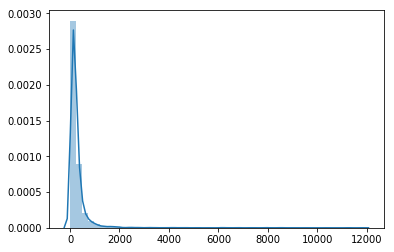

In [4]:
sns.distplot([len(_.split()) for _ in train_data])
plt.show()

In [5]:
from sklearn.metrics import roc_auc_score
def mean_roc_auc(y_true, y_pred):
    y = np.array(y_true.copy())
    probas = np.array(y_pred.copy())
    rs = []
    for i in range(len(class_list)):
        r = roc_auc_score((y==i).astype(int), probas[:, i])
        rs.append(r)
    return np.mean(rs)

In [6]:
vocab_file = 'D:\\PyCharm_Projects\\Fintech\\proj_5\\cased_L-12_H-768_A-12\\cased_L-12_H-768_A-12\\vocab.txt'
tokenizer = tokenization.FullTokenizer(
        vocab_file=vocab_file, do_lower_case=False)

max_seq_length = 500

def text2bert_input(text):
    tokens_a = tokenizer.tokenize(text)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0:(max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)
        
    return dict(
          input_ids=input_ids,
          input_mask=input_mask,
          segment_ids=segment_ids)

def gen(texts, labels):
    for text, label in zip(texts, labels):
        bert_input = text2bert_input(text)
        bert_input = {k: np.array(v) for k, v in bert_input.items()}
        yield bert_input, label

metadata = ['input_ids', 'input_mask', 'segment_ids']
def input_fn(texts, labels, params, is_training):
    dataset = tf.data.Dataset.from_generator(lambda:gen(texts, labels), 
                                            ({k: tf.int32 for k in metadata}, tf.int32),
                                              output_shapes=({k: tf.TensorShape([None]) for k in metadata}, tf.TensorShape([])))
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(texts))
    dataset = dataset.batch(params['batch_size'])
    if is_training:
        dataset = dataset.repeat()
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()


In [7]:
# TODO
# 1 - metrics
# 2 - validation


NUM_CLASSES = len(class_list)
head = tf.contrib.estimator.multi_class_head(NUM_CLASSES)

def create_model(features, params, is_training):
    def get_logits(x):
        """Creates a classification model."""
#         tags = set()
#         if is_training:
#             tags.add("train")
        bert_module = hub.Module(params['bert_hub_module_handle'], tags=None, trainable=False)
        bert_inputs = dict(
          input_ids=x['input_ids'],
          input_mask=x['input_mask'],
          segment_ids=x['segment_ids'])
        bert_outputs = bert_module(
          inputs=bert_inputs,
          signature="tokens",
          as_dict=True)

        # bert_outputs["pooled_output"] 
        output_layer = bert_outputs["sequence_output"]
        lstm_cell_1 = tf.nn.rnn_cell.GRUCell(100)
        outputs, final_states = tf.nn.dynamic_rnn(
            lstm_cell_1, output_layer, dtype=tf.float32)
        max_pool = tf.reduce_max(input_tensor=outputs, axis=1)
        mean_pool = tf.reduce_mean(input_tensor=outputs, axis=1)
        concat_outputs = tf.concat((mean_pool, max_pool, final_states),1)


        dropout_concat_outputs = tf.layers.dropout(inputs=concat_outputs, 
                                         rate=0.2, 
                                         training=is_training)
        dense = tf.layers.dense(dropout_concat_outputs, 100)
        model_output = tf.layers.dense(dense, params['num_labels'])
        return model_output
        
    with tf.variable_scope('encoder'):
        logits = get_logits(features)
    
    return logits


def model_fn(features, labels, mode, params): 
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)
    
    with tf.variable_scope('model'):
        logits = create_model(features, params, is_training)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        class_nums = tf.argmax(logits,1)
        probas = tf.nn.softmax(logits)
        predictions = {'y':class_nums, 'probas':probas}
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    if mode ==  tf.estimator.ModeKeys.EVAL:
        probas = tf.nn.softmax(logits)
        aucs = []
        for i in range(len(class_list)):
            auc = tf.metrics.auc(labels, probas[:, i])
            aucs.append(auc)
        mean_auc = tf.reduce_mean(aucs)
        tf.summary.scalar('mean_auc', mean_auc)
#         metrics = {'mean_auc': mean_auc}
        loss = tf.losses.sparse_softmax_cross_entropy(labels, logits)
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss)
    
    optimizer = tf.train.AdamOptimizer()
    
    def _train_op_fn(loss):
        return optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

    return head.create_estimator_spec(
        features=features,
        labels=labels,
        mode=mode,
        logits=logits, 
        train_op_fn=_train_op_fn)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [8]:
params = {'bert_hub_module_handle':'https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1',
         'num_labels': len(class_list),
         'batch_size': 4}

In [9]:
def get_part_of_data(data, y, count_per_class):
    new_data = []
    new_labels = []
    for label, _ in enumerate(class_list):
        idxs = np.where(y==label)[0]
#         print(idxs)
        idxs = np.random.choice(idxs, count_per_class).astype(int)
#         print(idxs)
        new_data.extend([_ for _ in data[idxs]])
        new_labels.extend([_ for _ in y[idxs]])
    return new_data, new_labels

In [17]:
aucs = []
for count_examples in range(1,20):
    model_dir = f'exp_{count_examples}'
    estimator = tf.estimator.Estimator(model_fn=model_fn,
                                       model_dir=model_dir,
                                       params=params)
    c_steps = int((count_examples*len(class_list)/params['batch_size'])*3)

    new_train_data, new_y_train = get_part_of_data(train_data, y_train, count_examples)

    estimator.train(input_fn=lambda: input_fn(train_data, y_train, params, is_training=True), steps=c_steps)

    new_test_data, new_y_test = get_part_of_data(test_data, y_test, 20)
    y_pred = estimator.predict(input_fn=lambda: input_fn(new_test_data, new_y_test, params, False))
    y_pred = [_ for _ in tqdm(y_pred)]

    auc = mean_roc_auc(new_y_test, [_['probas'] for _ in y_pred])
    print(count_examples, auc)
    aucs.append(auc)

INFO:tensorflow:Using default config.


I0409 00:16:54.305019  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7154DF2E8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 00:16:54.315967  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7154DF2E8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 00:16:54.372583  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:16:55.026193  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:16:56.579041  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:16:57.202374  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 00:16:57.205335  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 00:16:58.983701  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 00:17:00.220310  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:17:00.299099  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_2\model.ckpt.


I0409 00:17:03.310574  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_2\model.ckpt.


INFO:tensorflow:loss = 3.0231588, step = 0


I0409 00:18:10.680022  5412 tf_logging.py:115] loss = 3.0231588, step = 0


INFO:tensorflow:Saving checkpoints for 30 into exp_2\model.ckpt.


I0409 00:18:38.432511  5412 tf_logging.py:115] Saving checkpoints for 30 into exp_2\model.ckpt.


INFO:tensorflow:Loss for final step: 3.1579428.


I0409 00:18:44.533408  5412 tf_logging.py:115] Loss for final step: 3.1579428.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 00:18:44.691000  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:18:45.579538  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:18:47.168894  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:18:47.393297  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 00:18:47.969744  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_2\model.ckpt-30


I0409 00:18:47.996652  5412 tf_logging.py:115] Restoring parameters from exp_2\model.ckpt-30


INFO:tensorflow:Running local_init_op.


I0409 00:18:49.001676  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:18:49.077494  5412 tf_logging.py:115] Done running local_init_op.


2 0.6556907894736842
INFO:tensorflow:Using default config.


I0409 00:19:52.638234  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7C97FE4E0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 00:19:52.642230  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7C97FE4E0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 00:19:52.688996  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:19:53.215092  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:19:54.907599  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:19:55.610719  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 00:19:55.613705  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 00:19:57.710408  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 00:19:58.746777  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:19:58.825630  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_3\model.ckpt.


I0409 00:20:01.910469  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_3\model.ckpt.


INFO:tensorflow:loss = 3.7308183, step = 0


I0409 00:21:16.838068  5412 tf_logging.py:115] loss = 3.7308183, step = 0


INFO:tensorflow:Saving checkpoints for 45 into exp_3\model.ckpt.


I0409 00:21:59.224963  5412 tf_logging.py:115] Saving checkpoints for 45 into exp_3\model.ckpt.


INFO:tensorflow:Loss for final step: 3.5935092.


I0409 00:22:05.666180  5412 tf_logging.py:115] Loss for final step: 3.5935092.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 00:22:05.863682  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:22:06.459059  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:22:08.367969  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:22:08.632250  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 00:22:09.257604  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_3\model.ckpt-45


I0409 00:22:09.285502  5412 tf_logging.py:115] Restoring parameters from exp_3\model.ckpt-45


INFO:tensorflow:Running local_init_op.


I0409 00:22:10.266205  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:22:10.334011  5412 tf_logging.py:115] Done running local_init_op.


3 0.7484802631578946
INFO:tensorflow:Using default config.


I0409 00:23:15.122655  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7E2C6E400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 00:23:15.127646  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7E2C6E400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 00:23:15.200692  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:23:15.708451  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:23:17.548532  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:23:18.289554  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 00:23:18.293510  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 00:23:20.026730  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 00:23:21.039282  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:23:21.114083  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_4\model.ckpt.


I0409 00:23:24.258383  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_4\model.ckpt.


INFO:tensorflow:loss = 3.2770183, step = 0


I0409 00:24:33.180446  5412 tf_logging.py:115] loss = 3.2770183, step = 0


INFO:tensorflow:Saving checkpoints for 60 into exp_4\model.ckpt.


I0409 00:25:27.049969  5412 tf_logging.py:115] Saving checkpoints for 60 into exp_4\model.ckpt.


INFO:tensorflow:Loss for final step: 3.168765.


I0409 00:25:33.338470  5412 tf_logging.py:115] Loss for final step: 3.168765.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 00:25:33.499086  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:25:33.984689  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:25:35.639361  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:25:35.838828  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 00:25:36.224763  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_4\model.ckpt-60


I0409 00:25:36.250643  5412 tf_logging.py:115] Restoring parameters from exp_4\model.ckpt-60


INFO:tensorflow:Running local_init_op.


I0409 00:25:37.137585  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:25:37.201414  5412 tf_logging.py:115] Done running local_init_op.


4 0.7563618421052631
INFO:tensorflow:Using default config.


I0409 00:26:39.277238  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E72BCDA8D0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 00:26:39.282223  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E72BCDA8D0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 00:26:39.348423  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:26:39.834713  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:26:41.316094  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:26:42.026190  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 00:26:42.030181  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 00:26:43.444824  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 00:26:44.326558  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:26:44.391384  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_5\model.ckpt.


I0409 00:26:47.180980  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_5\model.ckpt.


INFO:tensorflow:loss = 2.5987468, step = 0


I0409 00:27:57.120472  5412 tf_logging.py:115] loss = 2.5987468, step = 0


INFO:tensorflow:Saving checkpoints for 75 into exp_5\model.ckpt.


I0409 00:29:06.986406  5412 tf_logging.py:115] Saving checkpoints for 75 into exp_5\model.ckpt.


INFO:tensorflow:Loss for final step: 2.4042494.


I0409 00:29:12.951113  5412 tf_logging.py:115] Loss for final step: 2.4042494.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 00:29:13.122495  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:29:13.898389  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:29:15.290696  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:29:15.510110  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 00:29:15.892085  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_5\model.ckpt-75


I0409 00:29:15.917856  5412 tf_logging.py:115] Restoring parameters from exp_5\model.ckpt-75


INFO:tensorflow:Running local_init_op.


I0409 00:29:16.807100  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:29:16.867969  5412 tf_logging.py:115] Done running local_init_op.


5 0.800967105263158
INFO:tensorflow:Using default config.


I0409 00:30:19.565360  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E71A15DB70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 00:30:19.569349  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E71A15DB70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 00:30:19.648549  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:30:20.430807  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:30:21.839456  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:30:22.428905  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 00:30:22.431878  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 00:30:23.909034  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 00:30:24.883397  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:30:24.958210  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_6\model.ckpt.


I0409 00:30:27.851499  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_6\model.ckpt.


INFO:tensorflow:loss = 3.4354646, step = 0


I0409 00:31:34.590641  5412 tf_logging.py:115] loss = 3.4354646, step = 0


INFO:tensorflow:Saving checkpoints for 90 into exp_6\model.ckpt.


I0409 00:32:56.089848  5412 tf_logging.py:115] Saving checkpoints for 90 into exp_6\model.ckpt.


INFO:tensorflow:Loss for final step: 2.4401312.


I0409 00:33:01.973093  5412 tf_logging.py:115] Loss for final step: 2.4401312.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 00:33:02.178540  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:33:02.929166  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:33:04.297506  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:33:04.501954  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 00:33:04.898899  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_6\model.ckpt-90


I0409 00:33:04.925804  5412 tf_logging.py:115] Restoring parameters from exp_6\model.ckpt-90


INFO:tensorflow:Running local_init_op.


I0409 00:33:05.794128  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:33:05.874905  5412 tf_logging.py:115] Done running local_init_op.


6 0.8142302631578948
INFO:tensorflow:Using default config.


I0409 00:34:07.507809  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7D3C44320>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 00:34:07.511827  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7D3C44320>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 00:34:07.862650  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:34:08.339408  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:34:09.839284  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:34:10.417731  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 00:34:10.421697  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 00:34:12.082804  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 00:34:12.934030  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:34:13.002825  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_7\model.ckpt.


I0409 00:34:15.759788  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_7\model.ckpt.


INFO:tensorflow:loss = 2.5024881, step = 0


I0409 00:35:22.570379  5412 tf_logging.py:115] loss = 2.5024881, step = 0


INFO:tensorflow:global_step/sec: 1.11369


I0409 00:36:52.361613  5412 tf_logging.py:115] global_step/sec: 1.11369


INFO:tensorflow:loss = 2.4505355, step = 100 (89.834 sec)


I0409 00:36:52.404499  5412 tf_logging.py:115] loss = 2.4505355, step = 100 (89.834 sec)


INFO:tensorflow:Saving checkpoints for 105 into exp_7\model.ckpt.


I0409 00:36:55.967971  5412 tf_logging.py:115] Saving checkpoints for 105 into exp_7\model.ckpt.


INFO:tensorflow:Loss for final step: 3.44344.


I0409 00:37:03.794069  5412 tf_logging.py:115] Loss for final step: 3.44344.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 00:37:04.056365  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:37:04.863234  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:37:06.366215  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:37:06.611533  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 00:37:07.063351  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_7\model.ckpt-105


I0409 00:37:07.085268  5412 tf_logging.py:115] Restoring parameters from exp_7\model.ckpt-105


INFO:tensorflow:Running local_init_op.


I0409 00:37:08.021763  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:37:08.084594  5412 tf_logging.py:115] Done running local_init_op.


7 0.8241249999999999
INFO:tensorflow:Using default config.


I0409 00:38:10.208895  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E54198EEF0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 00:38:10.214879  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E54198EEF0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 00:38:10.317602  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:38:11.140428  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:38:12.830882  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:38:13.479149  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 00:38:13.483141  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 00:38:15.235478  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 00:38:16.212855  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:38:16.280683  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_8\model.ckpt.


I0409 00:38:19.407022  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_8\model.ckpt.


INFO:tensorflow:loss = 3.8900928, step = 0


I0409 00:39:28.272222  5412 tf_logging.py:115] loss = 3.8900928, step = 0


INFO:tensorflow:global_step/sec: 1.12069


I0409 00:40:57.501770  5412 tf_logging.py:115] global_step/sec: 1.12069


INFO:tensorflow:loss = 2.7076287, step = 100 (89.285 sec)


I0409 00:40:57.557622  5412 tf_logging.py:115] loss = 2.7076287, step = 100 (89.285 sec)


INFO:tensorflow:Saving checkpoints for 120 into exp_8\model.ckpt.


I0409 00:41:14.415743  5412 tf_logging.py:115] Saving checkpoints for 120 into exp_8\model.ckpt.


INFO:tensorflow:Loss for final step: 1.5097406.


I0409 00:41:21.394526  5412 tf_logging.py:115] Loss for final step: 1.5097406.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 00:41:21.625907  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:41:22.126569  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:41:23.693379  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:41:23.905811  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 00:41:24.477284  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_8\model.ckpt-120


I0409 00:41:24.503610  5412 tf_logging.py:115] Restoring parameters from exp_8\model.ckpt-120


INFO:tensorflow:Running local_init_op.


I0409 00:41:25.405200  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:41:25.471043  5412 tf_logging.py:115] Done running local_init_op.


8 0.8570855263157895
INFO:tensorflow:Using default config.


I0409 00:42:27.110168  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E71A516F98>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 00:42:27.114160  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E71A516F98>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 00:42:27.210924  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:42:27.710561  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:42:29.248486  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:42:29.837872  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 00:42:29.841865  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 00:42:31.368779  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 00:42:32.292310  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:42:32.359131  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_9\model.ckpt.


I0409 00:42:35.227488  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_9\model.ckpt.


INFO:tensorflow:loss = 3.5565913, step = 0


I0409 00:43:43.030589  5412 tf_logging.py:115] loss = 3.5565913, step = 0


INFO:tensorflow:global_step/sec: 1.11956


I0409 00:45:12.352069  5412 tf_logging.py:115] global_step/sec: 1.11956


INFO:tensorflow:loss = 3.8153985, step = 100 (89.372 sec)


I0409 00:45:12.402935  5412 tf_logging.py:115] loss = 3.8153985, step = 100 (89.372 sec)


INFO:tensorflow:Saving checkpoints for 135 into exp_9\model.ckpt.


I0409 00:45:42.675983  5412 tf_logging.py:115] Saving checkpoints for 135 into exp_9\model.ckpt.


INFO:tensorflow:Loss for final step: 2.7140012.


I0409 00:45:49.516895  5412 tf_logging.py:115] Loss for final step: 2.7140012.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 00:45:49.752258  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:45:50.262923  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:45:51.962348  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:45:52.200710  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 00:45:52.611612  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_9\model.ckpt-135


I0409 00:45:52.638539  5412 tf_logging.py:115] Restoring parameters from exp_9\model.ckpt-135


INFO:tensorflow:Running local_init_op.


I0409 00:45:53.547110  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:45:53.614929  5412 tf_logging.py:115] Done running local_init_op.


9 0.8635855263157894
INFO:tensorflow:Using default config.


I0409 00:46:55.980902  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7CAA782B0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 00:46:55.984894  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7CAA782B0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 00:46:56.091633  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:46:56.604261  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:46:58.155113  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:46:58.916079  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 00:46:58.920044  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 00:47:00.331268  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 00:47:01.310662  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:47:01.385451  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_10\model.ckpt.


I0409 00:47:04.316949  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_10\model.ckpt.


INFO:tensorflow:loss = 3.0070481, step = 0


I0409 00:48:12.113137  5412 tf_logging.py:115] loss = 3.0070481, step = 0


INFO:tensorflow:global_step/sec: 1.11083


I0409 00:49:42.136180  5412 tf_logging.py:115] global_step/sec: 1.11083


INFO:tensorflow:loss = 2.9249434, step = 100 (90.067 sec)


I0409 00:49:42.180390  5412 tf_logging.py:115] loss = 2.9249434, step = 100 (90.067 sec)


INFO:tensorflow:Saving checkpoints for 150 into exp_10\model.ckpt.


I0409 00:50:26.003474  5412 tf_logging.py:115] Saving checkpoints for 150 into exp_10\model.ckpt.


INFO:tensorflow:Loss for final step: 2.2720103.


I0409 00:50:33.218147  5412 tf_logging.py:115] Loss for final step: 2.2720103.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 00:50:33.446544  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:50:34.228472  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:50:35.660618  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:50:35.885017  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 00:50:36.308908  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_10\model.ckpt-150


I0409 00:50:36.336809  5412 tf_logging.py:115] Restoring parameters from exp_10\model.ckpt-150


INFO:tensorflow:Running local_init_op.


I0409 00:50:37.217480  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:50:37.291265  5412 tf_logging.py:115] Done running local_init_op.


10 0.8940657894736841
INFO:tensorflow:Using default config.


I0409 00:51:40.147851  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_11', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7CAA7D7B8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 00:51:40.151837  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_11', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7CAA7D7B8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 00:51:40.287472  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:51:41.029488  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:51:42.467642  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:51:43.082026  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 00:51:43.085992  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 00:51:44.521152  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 00:51:45.423738  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:51:45.490558  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_11\model.ckpt.


I0409 00:51:48.371855  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_11\model.ckpt.


INFO:tensorflow:loss = 3.5723727, step = 0


I0409 00:52:58.151795  5412 tf_logging.py:115] loss = 3.5723727, step = 0


INFO:tensorflow:global_step/sec: 1.1076


I0409 00:54:28.435750  5412 tf_logging.py:115] global_step/sec: 1.1076


INFO:tensorflow:loss = 3.062347, step = 100 (90.331 sec)


I0409 00:54:28.482626  5412 tf_logging.py:115] loss = 3.062347, step = 100 (90.331 sec)


INFO:tensorflow:Saving checkpoints for 165 into exp_11\model.ckpt.


I0409 00:55:25.501924  5412 tf_logging.py:115] Saving checkpoints for 165 into exp_11\model.ckpt.


INFO:tensorflow:Loss for final step: 2.621601.


I0409 00:55:32.620227  5412 tf_logging.py:115] Loss for final step: 2.621601.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 00:55:32.864605  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:55:33.646482  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:55:35.084637  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:55:35.309036  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 00:55:35.884498  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_11\model.ckpt-165


I0409 00:55:35.908434  5412 tf_logging.py:115] Restoring parameters from exp_11\model.ckpt-165


INFO:tensorflow:Running local_init_op.


I0409 00:55:36.815009  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:55:36.879862  5412 tf_logging.py:115] Done running local_init_op.


11 0.8729342105263157
INFO:tensorflow:Using default config.


I0409 00:56:38.808243  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_12', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E540036208>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 00:56:38.813229  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_12', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E540036208>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 00:56:38.932909  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:56:39.438556  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 00:56:41.025313  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 00:56:41.636677  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 00:56:41.640672  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 00:56:43.230417  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 00:56:44.215781  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 00:56:44.286592  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_12\model.ckpt.


I0409 00:56:47.151932  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_12\model.ckpt.


INFO:tensorflow:loss = 2.8623738, step = 0


I0409 00:57:54.343163  5412 tf_logging.py:115] loss = 2.8623738, step = 0


INFO:tensorflow:global_step/sec: 1.10202


I0409 00:59:25.084213  5412 tf_logging.py:115] global_step/sec: 1.10202


INFO:tensorflow:loss = 3.0947747, step = 100 (90.797 sec)


I0409 00:59:25.140065  5412 tf_logging.py:115] loss = 3.0947747, step = 100 (90.797 sec)


INFO:tensorflow:Saving checkpoints for 180 into exp_12\model.ckpt.


I0409 01:00:36.306409  5412 tf_logging.py:115] Saving checkpoints for 180 into exp_12\model.ckpt.


INFO:tensorflow:Loss for final step: 1.0816839.


I0409 01:00:43.396780  5412 tf_logging.py:115] Loss for final step: 1.0816839.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 01:00:43.632151  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:00:44.129290  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:00:45.714053  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 01:00:45.938453  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 01:00:46.513915  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_12\model.ckpt-180


I0409 01:00:46.537858  5412 tf_logging.py:115] Restoring parameters from exp_12\model.ckpt-180


INFO:tensorflow:Running local_init_op.


I0409 01:00:47.432235  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 01:00:47.498067  5412 tf_logging.py:115] Done running local_init_op.


12 0.914078947368421
INFO:tensorflow:Using default config.


I0409 01:01:49.785900  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_13', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7CBFDD400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 01:01:49.791886  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_13', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7CBFDD400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 01:01:49.915585  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:01:50.477050  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:01:52.339071  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 01:01:53.186807  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 01:01:53.190796  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 01:01:54.966048  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 01:01:56.122981  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 01:01:56.211718  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_13\model.ckpt.


I0409 01:01:59.645556  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_13\model.ckpt.


INFO:tensorflow:loss = 3.5324066, step = 0


I0409 01:03:07.485906  5412 tf_logging.py:115] loss = 3.5324066, step = 0


INFO:tensorflow:global_step/sec: 1.11426


I0409 01:04:37.231688  5412 tf_logging.py:115] global_step/sec: 1.11426


INFO:tensorflow:loss = 2.133104, step = 100 (89.800 sec)


I0409 01:04:37.285536  5412 tf_logging.py:115] loss = 2.133104, step = 100 (89.800 sec)


INFO:tensorflow:Saving checkpoints for 195 into exp_13\model.ckpt.


I0409 01:06:01.142340  5412 tf_logging.py:115] Saving checkpoints for 195 into exp_13\model.ckpt.


INFO:tensorflow:Loss for final step: 2.6678317.


I0409 01:06:08.213101  5412 tf_logging.py:115] Loss for final step: 2.6678317.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 01:06:08.441520  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:06:08.956140  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:06:10.732392  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 01:06:10.965767  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 01:06:11.397612  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_13\model.ckpt-195


I0409 01:06:11.421522  5412 tf_logging.py:115] Restoring parameters from exp_13\model.ckpt-195


INFO:tensorflow:Running local_init_op.


I0409 01:06:12.328123  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 01:06:12.395915  5412 tf_logging.py:115] Done running local_init_op.


13 0.9093815789473684
INFO:tensorflow:Using default config.


I0409 01:07:15.165291  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_14', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7CAE02400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 01:07:15.172268  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_14', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7CAE02400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 01:07:15.359766  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:07:15.995066  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:07:17.895984  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 01:07:18.890353  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 01:07:18.894318  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 01:07:20.462987  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 01:07:21.645796  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 01:07:21.732564  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_14\model.ckpt.


I0409 01:07:25.014815  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_14\model.ckpt.


INFO:tensorflow:loss = 3.1695204, step = 0


I0409 01:08:34.334482  5412 tf_logging.py:115] loss = 3.1695204, step = 0


INFO:tensorflow:global_step/sec: 1.10314


I0409 01:10:04.983862  5412 tf_logging.py:115] global_step/sec: 1.10314


INFO:tensorflow:loss = 1.9105206, step = 100 (90.699 sec)


I0409 01:10:05.033702  5412 tf_logging.py:115] loss = 1.9105206, step = 100 (90.699 sec)


INFO:tensorflow:global_step/sec: 1.11584


I0409 01:11:34.602657  5412 tf_logging.py:115] global_step/sec: 1.11584


INFO:tensorflow:loss = 1.9767982, step = 200 (89.574 sec)


I0409 01:11:34.607643  5412 tf_logging.py:115] loss = 1.9767982, step = 200 (89.574 sec)


INFO:tensorflow:Saving checkpoints for 210 into exp_14\model.ckpt.


I0409 01:11:42.734910  5412 tf_logging.py:115] Saving checkpoints for 210 into exp_14\model.ckpt.


INFO:tensorflow:Loss for final step: 1.469412.


I0409 01:11:49.518612  5412 tf_logging.py:115] Loss for final step: 1.469412.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 01:11:49.757000  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:11:50.547502  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:11:52.014579  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 01:11:52.244962  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 01:11:52.666834  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_14\model.ckpt-210


I0409 01:11:52.689783  5412 tf_logging.py:115] Restoring parameters from exp_14\model.ckpt-210


INFO:tensorflow:Running local_init_op.


I0409 01:11:53.603356  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 01:11:53.669154  5412 tf_logging.py:115] Done running local_init_op.


14 0.8995065789473683
INFO:tensorflow:Using default config.


I0409 01:12:55.499069  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_15', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7CD583A90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 01:12:55.504059  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_15', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E7CD583A90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 01:12:55.661661  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:12:56.471499  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:12:58.198849  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 01:12:59.051602  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 01:12:59.056557  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 01:13:00.669493  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 01:13:01.899202  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 01:13:01.988963  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_15\model.ckpt.


I0409 01:13:05.431790  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_15\model.ckpt.


INFO:tensorflow:loss = 3.4417386, step = 0


I0409 01:14:13.217112  5412 tf_logging.py:115] loss = 3.4417386, step = 0


INFO:tensorflow:global_step/sec: 1.10394


I0409 01:15:43.801891  5412 tf_logging.py:115] global_step/sec: 1.10394


INFO:tensorflow:loss = 2.828509, step = 100 (90.631 sec)


I0409 01:15:43.847770  5412 tf_logging.py:115] loss = 2.828509, step = 100 (90.631 sec)


INFO:tensorflow:global_step/sec: 1.11844


I0409 01:17:13.212015  5412 tf_logging.py:115] global_step/sec: 1.11844


INFO:tensorflow:loss = 2.1453524, step = 200 (89.369 sec)


I0409 01:17:13.217020  5412 tf_logging.py:115] loss = 2.1453524, step = 200 (89.369 sec)


INFO:tensorflow:Saving checkpoints for 225 into exp_15\model.ckpt.


I0409 01:17:34.597869  5412 tf_logging.py:115] Saving checkpoints for 225 into exp_15\model.ckpt.


INFO:tensorflow:Loss for final step: 2.9496694.


I0409 01:17:41.520568  5412 tf_logging.py:115] Loss for final step: 2.9496694.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 01:17:41.752980  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:17:42.534889  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:17:44.031885  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 01:17:44.273235  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 01:17:44.859642  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_15\model.ckpt-225


I0409 01:17:44.886569  5412 tf_logging.py:115] Restoring parameters from exp_15\model.ckpt-225


INFO:tensorflow:Running local_init_op.


I0409 01:17:45.792146  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 01:17:45.859965  5412 tf_logging.py:115] Done running local_init_op.


15 0.9147105263157893
INFO:tensorflow:Using default config.


I0409 01:18:48.278476  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_16', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E719EE4EF0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 01:18:48.284463  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_16', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E719EE4EF0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 01:18:48.478939  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:18:49.037444  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:18:50.838657  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 01:18:51.690350  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 01:18:51.694341  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 01:18:53.451640  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 01:18:54.599571  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 01:18:54.685342  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_16\model.ckpt.


I0409 01:18:58.242829  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_16\model.ckpt.


INFO:tensorflow:loss = 2.7820783, step = 0


I0409 01:20:07.034191  5412 tf_logging.py:115] loss = 2.7820783, step = 0


INFO:tensorflow:global_step/sec: 1.10134


I0409 01:21:37.832061  5412 tf_logging.py:115] global_step/sec: 1.10134


INFO:tensorflow:loss = 2.9401224, step = 100 (90.850 sec)


I0409 01:21:37.883924  5412 tf_logging.py:115] loss = 2.9401224, step = 100 (90.850 sec)


INFO:tensorflow:global_step/sec: 1.11353


I0409 01:23:07.636288  5412 tf_logging.py:115] global_step/sec: 1.11353


INFO:tensorflow:loss = 2.5989232, step = 200 (89.757 sec)


I0409 01:23:07.641259  5412 tf_logging.py:115] loss = 2.5989232, step = 200 (89.757 sec)


INFO:tensorflow:Saving checkpoints for 240 into exp_16\model.ckpt.


I0409 01:23:42.537082  5412 tf_logging.py:115] Saving checkpoints for 240 into exp_16\model.ckpt.


INFO:tensorflow:Loss for final step: 1.2499449.


I0409 01:23:49.360123  5412 tf_logging.py:115] Loss for final step: 1.2499449.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 01:23:49.600481  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:23:50.106126  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:23:51.744746  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 01:23:52.146672  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 01:23:52.580511  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_16\model.ckpt-240


I0409 01:23:52.602452  5412 tf_logging.py:115] Restoring parameters from exp_16\model.ckpt-240


INFO:tensorflow:Running local_init_op.


I0409 01:23:53.516010  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 01:23:53.583829  5412 tf_logging.py:115] Done running local_init_op.


16 0.9169736842105263
INFO:tensorflow:Using default config.


I0409 01:24:56.139757  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_17', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E715B04DA0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 01:24:56.145740  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_17', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E715B04DA0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 01:24:56.302319  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:24:56.866810  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:24:58.672980  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 01:24:59.532684  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 01:24:59.536676  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 01:25:01.304945  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 01:25:02.444896  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 01:25:02.538644  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_17\model.ckpt.


I0409 01:25:06.028314  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_17\model.ckpt.


INFO:tensorflow:loss = 3.1247973, step = 0


I0409 01:26:14.606901  5412 tf_logging.py:115] loss = 3.1247973, step = 0


INFO:tensorflow:global_step/sec: 1.10519


I0409 01:27:45.088108  5412 tf_logging.py:115] global_step/sec: 1.10519


INFO:tensorflow:loss = 3.520626, step = 100 (90.537 sec)


I0409 01:27:45.143959  5412 tf_logging.py:115] loss = 3.520626, step = 100 (90.537 sec)


INFO:tensorflow:global_step/sec: 1.11088


I0409 01:29:15.106430  5412 tf_logging.py:115] global_step/sec: 1.11088


INFO:tensorflow:loss = 2.857439, step = 200 (89.966 sec)


I0409 01:29:15.110421  5412 tf_logging.py:115] loss = 2.857439, step = 200 (89.966 sec)


INFO:tensorflow:Saving checkpoints for 255 into exp_17\model.ckpt.


I0409 01:30:03.566092  5412 tf_logging.py:115] Saving checkpoints for 255 into exp_17\model.ckpt.


INFO:tensorflow:Loss for final step: 1.7629707.


I0409 01:30:09.984337  5412 tf_logging.py:115] Loss for final step: 1.7629707.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 01:30:10.225719  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:30:10.731339  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:30:12.509584  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 01:30:12.756924  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 01:30:13.184780  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_17\model.ckpt-255


I0409 01:30:13.205722  5412 tf_logging.py:115] Restoring parameters from exp_17\model.ckpt-255


INFO:tensorflow:Running local_init_op.


I0409 01:30:14.141221  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 01:30:14.212033  5412 tf_logging.py:115] Done running local_init_op.


17 0.9288684210526317
INFO:tensorflow:Using default config.


I0409 01:31:17.565865  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_18', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E71A3EED30>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 01:31:17.572847  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_18', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E71A3EED30>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 01:31:17.738429  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:31:18.298903  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:31:20.125020  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 01:31:21.143326  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 01:31:21.147287  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 01:31:22.760998  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 01:31:23.987718  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 01:31:24.082437  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_18\model.ckpt.


I0409 01:31:27.634679  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_18\model.ckpt.


INFO:tensorflow:loss = 3.157928, step = 0


I0409 01:32:36.566394  5412 tf_logging.py:115] loss = 3.157928, step = 0


INFO:tensorflow:global_step/sec: 1.10176


I0409 01:34:07.330641  5412 tf_logging.py:115] global_step/sec: 1.10176


INFO:tensorflow:loss = 2.969096, step = 100 (90.816 sec)


I0409 01:34:07.382503  5412 tf_logging.py:115] loss = 2.969096, step = 100 (90.816 sec)


INFO:tensorflow:global_step/sec: 1.10921


I0409 01:35:37.484631  5412 tf_logging.py:115] global_step/sec: 1.10921


INFO:tensorflow:loss = 2.882997, step = 200 (90.106 sec)


I0409 01:35:37.488620  5412 tf_logging.py:115] loss = 2.882997, step = 200 (90.106 sec)


INFO:tensorflow:Saving checkpoints for 270 into exp_18\model.ckpt.


I0409 01:36:39.885518  5412 tf_logging.py:115] Saving checkpoints for 270 into exp_18\model.ckpt.


INFO:tensorflow:Loss for final step: 2.3022058.


I0409 01:36:46.045174  5412 tf_logging.py:115] Loss for final step: 2.3022058.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 01:36:46.261176  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:36:47.019056  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:36:48.375081  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 01:36:48.582494  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 01:36:48.968966  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_18\model.ckpt-270


I0409 01:36:48.995348  5412 tf_logging.py:115] Restoring parameters from exp_18\model.ckpt-270


INFO:tensorflow:Running local_init_op.


I0409 01:36:49.851795  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 01:36:49.917618  5412 tf_logging.py:115] Done running local_init_op.


18 0.9224605263157896
INFO:tensorflow:Using default config.


I0409 01:37:51.195802  5412 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'exp_19', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E54037E908>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0409 01:37:51.199789  5412 tf_logging.py:115] Using config: {'_model_dir': 'exp_19', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E54037E908>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0409 01:37:51.381403  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:37:52.107671  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:37:53.496987  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 01:37:54.067456  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0409 01:37:54.070449  5412 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0409 01:37:55.459171  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0409 01:37:56.367657  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 01:37:56.437072  5412 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into exp_19\model.ckpt.


I0409 01:37:59.359565  5412 tf_logging.py:115] Saving checkpoints for 0 into exp_19\model.ckpt.


INFO:tensorflow:loss = 4.205325, step = 0


I0409 01:39:04.215612  5412 tf_logging.py:115] loss = 4.205325, step = 0


INFO:tensorflow:global_step/sec: 1.07325


I0409 01:40:37.389604  5412 tf_logging.py:115] global_step/sec: 1.07325


INFO:tensorflow:loss = 3.013291, step = 100 (93.217 sec)


I0409 01:40:37.432555  5412 tf_logging.py:115] loss = 3.013291, step = 100 (93.217 sec)


INFO:tensorflow:global_step/sec: 1.05797


I0409 01:42:11.910467  5412 tf_logging.py:115] global_step/sec: 1.05797


INFO:tensorflow:loss = 2.0535598, step = 200 (94.484 sec)


I0409 01:42:11.916452  5412 tf_logging.py:115] loss = 2.0535598, step = 200 (94.484 sec)


INFO:tensorflow:Saving checkpoints for 285 into exp_19\model.ckpt.


I0409 01:43:30.311918  5412 tf_logging.py:115] Saving checkpoints for 285 into exp_19\model.ckpt.


INFO:tensorflow:Loss for final step: 1.573205.


I0409 01:43:36.707192  5412 tf_logging.py:115] Loss for final step: 1.573205.


A Jupyter Widget

INFO:tensorflow:Calling model_fn.


I0409 01:43:36.924894  5412 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:43:37.471141  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 01:43:39.033983  5412 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0409 01:43:39.228295  5412 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0409 01:43:39.614817  5412 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from exp_19\model.ckpt-285


I0409 01:43:39.630436  5412 tf_logging.py:115] Restoring parameters from exp_19\model.ckpt-285


INFO:tensorflow:Running local_init_op.


I0409 01:43:40.505232  5412 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0409 01:43:40.567742  5412 tf_logging.py:115] Done running local_init_op.


19 0.9201315789473684


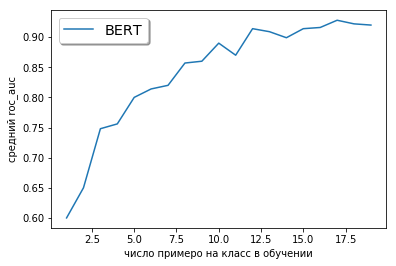

In [23]:
plt.plot(list(range(1,20)), aucs, label='BERT')
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xlabel('число примеро на класс в обучении')
plt.ylabel('средний roc_auc')
plt.show()